In [3]:

import pandas as pd
import numpy as np
import os

raw_data = pd.read_csv('data/Crash_Data.csv')

#print(data.describe())
print(raw_data.columns)

Index(['X', 'Y', 'OBJECTID', 'DOCUMENT_NBR', 'CRASH_YEAR', 'CRASH_DT',
       'CRASH_MILITARY_TM', 'CRASH_SEVERITY', 'K_PEOPLE', 'A_PEOPLE',
       'B_PEOPLE', 'C_PEOPLE', 'PERSONS_INJURED', 'PEDESTRIANS_KILLED',
       'PEDESTRIANS_INJURED', 'VEH_COUNT', 'COLLISION_TYPE',
       'WEATHER_CONDITION', 'LIGHT_CONDITION', 'ROADWAY_SURFACE_COND',
       'RELATION_TO_ROADWAY', 'ROADWAY_ALIGNMENT', 'ROADWAY_SURFACE_TYPE',
       'ROADWAY_DEFECT', 'ROADWAY_DESCRIPTION', 'INTERSECTION_TYPE',
       'TRAFFIC_CONTROL_TYPE', 'TRFC_CTRL_STATUS_TYPE', 'WORK_ZONE_RELATED',
       'WORK_ZONE_LOCATION', 'WORK_ZONE_TYPE', 'SCHOOL_ZONE',
       'FIRST_HARMFUL_EVENT', 'FIRST_HARMFUL_EVENT_LOC', 'ALCOHOL_NOTALCOHOL',
       'ANIMAL', 'BELTED_UNBELTED', 'BIKE_NONBIKE', 'DISTRACTED_NOTDISTRACTED',
       'DROWSY_NOTDROWSY', 'DRUG_NODRUG', 'GR_NOGR', 'HITRUN_NOT_HITRUN',
       'LGTRUCK_NONLGTRUCK', 'MOTOR_NONMOTOR', 'PED_NONPED', 'SPEED_NOTSPEED',
       'SPEED_DIFF_MAX', 'RD_TYPE', 'INTERSECTION_ANALYSIS',

In [4]:
columns_list = [
    'RNS_MP', 
    'PLAN_DISTRICT', 
    'MPO_NAME', 
    'NODE', 
    'OFFSET', 
    'VSP', 
    'JURIS_CODE', 
    'NIGHT', 
    'RD_TYPE',
    'DOCUMENT_NBR', 
    'OBJECTID', 
    'CRASH_YEAR'
]

data = raw_data.drop(columns=columns_list)
data['month'] = pd.to_datetime(data['CRASH_DT']).dt.strftime('%B')
data = data.drop(columns=['CRASH_DT'])
data = data.dropna(subset=['X', 'Y'])

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
numerical_columns = data.select_dtypes(include=[np.number]).columns
categorical_columns = data.select_dtypes(include=['object']).columns

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, numerical_columns),
        ("cat", OneHotEncoder(handle_unknown='ignore'), categorical_columns),
    ])

data_prepared = full_pipeline.fit_transform(data)

In [7]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(data_prepared)
labels = kmeans.predict(data_prepared)
centers = kmeans.cluster_centers_

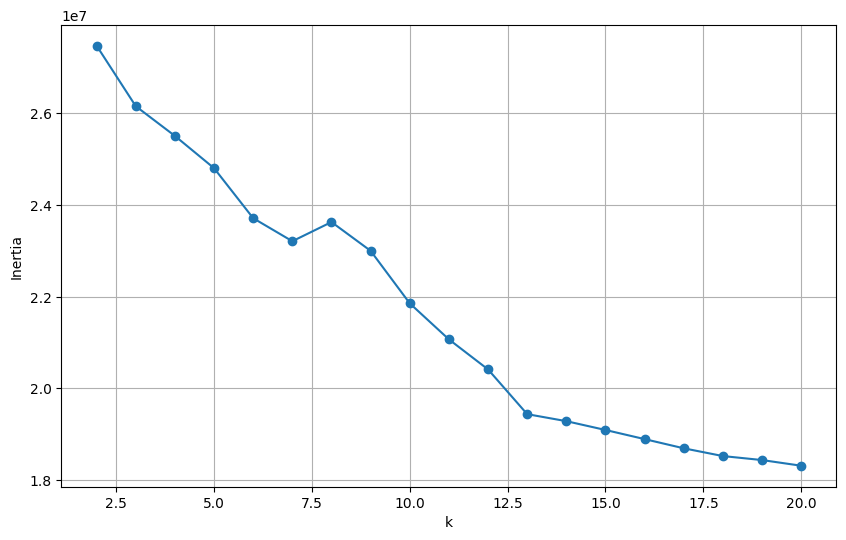

In [12]:
import matplotlib.pyplot as plt

inertia_values = []

min_k, max_k = 2, 21

for k in range(min_k, max_k):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_prepared)
    inertia_values.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(min_k, max_k), inertia_values, marker='o', linestyle='-')
plt.xlabel("k")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()

The plot above shows a clear change in the rate at which inertia decreases from 13 clusters onwards. Thus, we use k=13 going forward.

In [13]:
K = 13
kmeans = KMeans(n_clusters=K, random_state=42)
kmeans.fit(data_prepared)
labels = kmeans.predict(data_prepared)
centers = kmeans.cluster_centers_

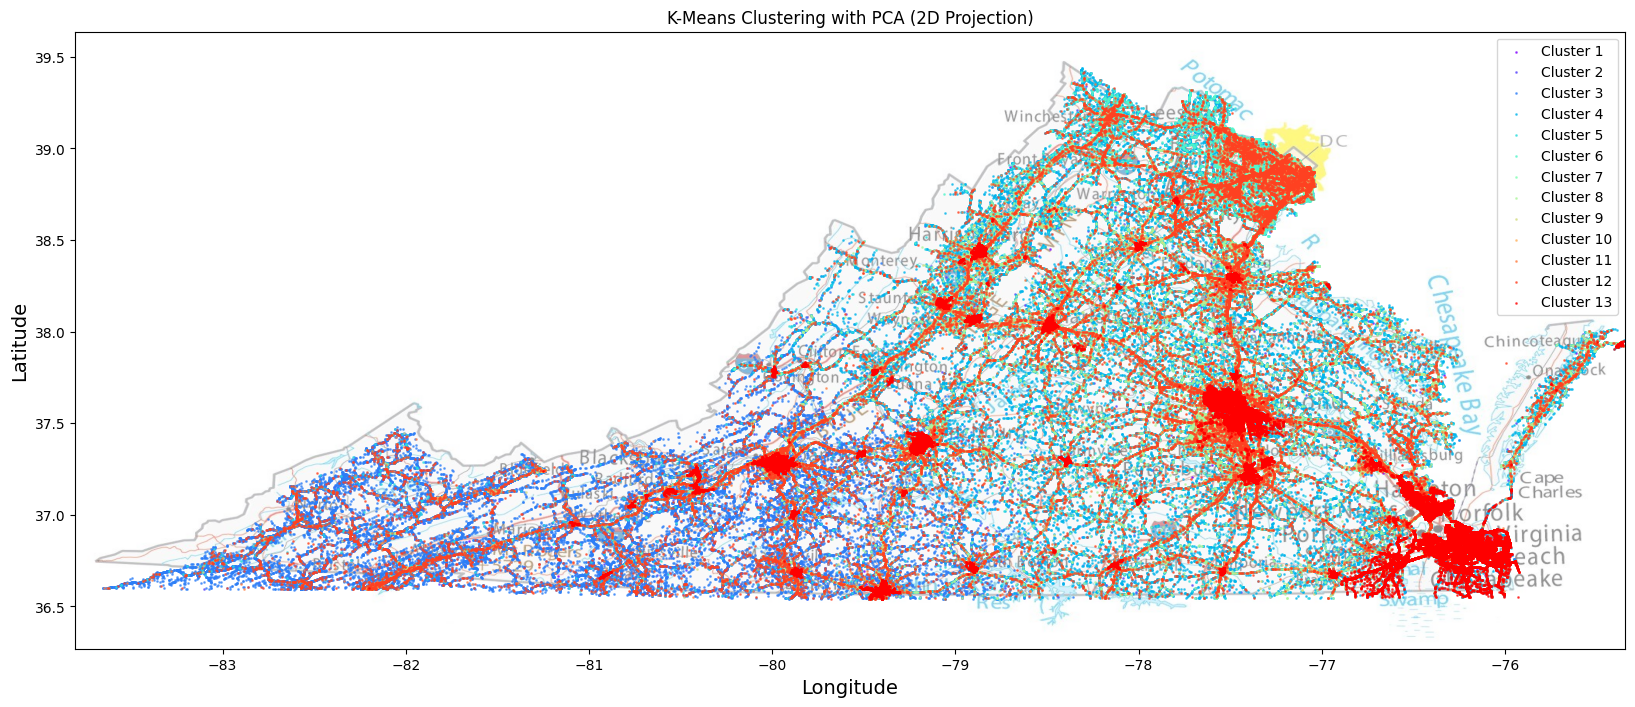

In [35]:
from sklearn.decomposition import PCA
import matplotlib.image as mpimg
from matplotlib.colors import ListedColormap
import matplotlib

base_cmap = matplotlib.colormaps["rainbow"]
colors = base_cmap(np.linspace(0, 1, K)) # get evenly spaced colors from the map
cmap = ListedColormap(colors)

geo_columns = ['X', 'Y']

# Extract longitude and latitude before transformations
geo_data = data[geo_columns].values

pca = PCA(n_components=2)
data_2d = pca.fit_transform(data_prepared)

x_min, x_max = np.min(geo_data[:, 0]), np.max(geo_data[:, 0])
y_min, y_max = np.min(geo_data[:, 1]), np.max(geo_data[:, 1])

# Plot background image (map of VA)
plt.figure(figsize=(20, 10))
bg_map = mpimg.imread('./virginia_map.jpg')
plt.imshow(bg_map, extent=[x_min-0.15, x_max, y_min-0.27, y_max+0.2], alpha=0.5, zorder=0)

# Plot each cluster with a different color
for i in range(K):
    # color = cmap(i)
    plt.scatter(geo_data[labels == i, 0], geo_data[labels == i, 1], color=cmap(i),
                label=f'Cluster {i + 1}', alpha=0.6, s=1, zorder=1)

# # Plot centroids
# centers_2d = pca.transform(centers)
# plt.scatter(centers[:, 0], centers[:, 1], s=300, c='red', marker='X', label='Centroids')

plt.title('K-Means Clustering with PCA (2D Projection)')
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.legend()
plt.show()

## Classification

In [46]:
from sklearn.model_selection import train_test_split

columns_list = [
    'K_PEOPLE',
    'A_PEOPLE',
    'B_PEOPLE',
    'C_PEOPLE',
    'PERSONS_INJURED',
    'PEDESTRIANS_KILLED',
    'PEDESTRIANS_INJURED'
]

severity_mapping = {
    'O': 0,  # property damage only
    'C': 1,  # minor injury
    'B': 2,  # medium injury
    'A': 3,  # major injury
    'K': 4   # death(s)
}

#data = data.drop(columns=columns_list)
data['severity_num'] = data['CRASH_SEVERITY'].map(severity_mapping)
train_set_prepared, test_set_prepared = train_test_split(data, test_size=0.2, random_state=42)

X_train = train_set_prepared.drop('severity_num', axis=1)
X_test = test_set_prepared.drop('severity_num', axis=1)
y_train = train_set_prepared['severity_num']
y_test = test_set_prepared['severity_num']

data_class = full_pipeline.fit_transform(data)

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

rows_with_O = data_class[data_class['severity_num'] == 'O']

rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)
print(rows_with_O)

# Evaluate the classifier.
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

IndexError: Index dimension must be 1 or 2